# Face Recognition Using Siamese Network

We will understand the siamese network by building the face recognition model. The objective of our network is to understand whether two faces are similar or dissimilar. We use AT & T's the Database of Faces which can be downloaded from here (https://www.cl.cam.ac.uk/research/dtg/attarchive/facedatabase.html)

Once you have downloaded and extracted the archive, you can see the folders like s1, s2 up to s40 as shown here:

In [227]:
import re
import numpy as np
from PIL import Image

from sklearn.model_selection import train_test_split
from keras import backend as K
from keras.layers import Activation
from keras.layers import Input, Lambda, Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from keras.models import Sequential, Model
from keras.optimizers import RMSprop
from keras.datasets import mnist

from matplotlib import pyplot as plt
from skimage.measure import compare_ssim as get_similarity

Now, we define another function get_data for generating our data. As we know, for the Siamese network, data should be in the form of pairs (genuine and imposite) with a binary label.

First, we read the images (img1, img2) from the same directory and store them in the x_genuine_pair array and assign y_genuine to 1. Next, we read the images (img1, img2) from the different directory and store them in the x_imposite pair and assign y_imposite to 0.

Finally, we concatenate both x_genuine_pair, x_imposite to X and y_genuine, y_imposite to Y:

In [228]:
def get_data(ch=None):
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    
    #total size
    total_sample_size = len(x_train)
    
    #get the new size
    dim1 = x_train[0].shape[0]
    dim2 = x_train[0].shape[1]

    #initialize the numpy array with the shape of [total_sample, no_of_pairs, dim1, dim2]
    x_pair = np.zeros([total_sample_size, 2, dim1, dim2, 1])  # 2 is for pairs
    y = np.zeros([total_sample_size, 2])  # 2 is for pairs

    #all indices of the images
    indices = np.array(range(total_sample_size))
    
    #store the images to the initialized numpy array
    np.random.shuffle(indices)
    order1 = indices.copy()
    x_pair[:, 0, :, :, 0] = x_train[order1]
    
    np.random.shuffle(indices)
    order2 = indices.copy()
    x_pair[:, 1, :, :, 0] = x_train[order2]

    #the proposed similarities by ssim
    for i in range(total_sample_size):
        y[i][1] = 0 if y_train[order1[i]] == y_train[order2[i]] else 1
        y[i][0] = 1 - get_similarity(
            x_pair[:, 0][i],
            x_pair[:, 1][i],
            multichannel=True
        )
        
    return x_pair, y

In [229]:
X, Y = get_data()

In [230]:
X.shape

(60000, 2, 28, 28, 1)

In [231]:
Y.shape

(60000, 2)

In [232]:
image_index = 4

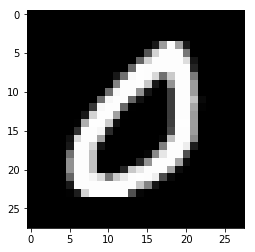

In [233]:
plt.imshow(X[image_index, 0, :, :, 0]/255, vmin=0, vmax=1, cmap='gray')

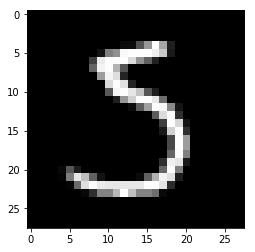

In [234]:
plt.imshow(X[image_index, 1, :, :, 0]/255, vmin=0, vmax=1, cmap='gray')

In [235]:
Y[image_index]

array([0.83406944, 1.        ])

Next, we split our data for training and testing with 75% training and 25% testing proportions:

In [236]:
x_train, x_test, Y_train, Y_test = train_test_split(X, Y, test_size=.25)
Y

array([[0.95638861, 1.        ],
       [0.89594004, 1.        ],
       [0.82129111, 1.        ],
       ...,
       [0.49350389, 0.        ],
       [0.71729424, 1.        ],
       [0.58660328, 1.        ]])

In [237]:
y_actual_train = np.expand_dims(Y_train[:, 1], axis=1)
y_actual_test = np.expand_dims(Y_test[:, 1], axis=1)

y_train = np.expand_dims(Y_train[:, 0], axis=1)
y_test = np.expand_dims(Y_test[:, 0], axis=1)

In [256]:
max_mse = 255**2

def get_similarity(img1, img2, multichannel=None):
    return ((img1 - img2)**2).mean() / max_mse

In [262]:
sample_size = 100
n_iters = 3

upper_bound_threshold = 0.0075
lower_bound_threshold = 0.01


ss = int(sample_size/2)

similar_pairs_indices = np.where(Y_test[:, 1] == 0)[0]
dissimilar_pairs_indices = np.where(Y_test[:, 1] == 1)[0]

accuracys = []

for n_iter in range(n_iters):
    np.random.shuffle(similar_pairs_indices)
    np.random.shuffle(dissimilar_pairs_indices)

    pairs_indices = np.concatenate([similar_pairs_indices[:ss], dissimilar_pairs_indices[:ss]], axis=0)
    np.random.shuffle(pairs_indices)

    image_pairs = x_test[pairs_indices, 0]

    similar = []
    dissimilar = []

    confusion_matrix = np.zeros((2, 2))

    for i, img in enumerate(image_pairs):
        best_sim = best_sim_index = None

        for j, imgx in enumerate(image_pairs):
            if i == j:
                continue

            sim = get_similarity(img, imgx, multichannel=True) 
#             print(sim)

            if best_sim is None:
                best_sim = sim
                best_sim_index = pairs_indices[j]

            elif sim > best_sim:
                best_sim = sim
                best_sim_index = pairs_indices[j]
        
        #the actual difference
        actual = int(Y_test[pairs_indices[i], 1])
        
        #checking for right and wrong
        if best_sim > upper_bound_threshold:
            prediction = 0
            
        elif best_sim < lower_bound_threshold:
            prediction = 1
            
        else:
            continue
        
        #update conf matrix
        confusion_matrix[actual][prediction] += 1
        
    similar = np.array(similar)
    dissimilar = np.array(dissimilar)

    s1, s2 = confusion_matrix.sum(1)
    
    result = (confusion_matrix * np.diag((1, 1))).sum(1) / np.array([s1, s2])
    accuracy = result.mean()
    
    accuracys.append(accuracy)

    print(f"Confusion Matrix({n_iter+1})\n==================")
    print(confusion_matrix)

    print(f"{len(similar)} similar and {len(dissimilar)} dissimilar loaded")
    print(f"{s1} similar and {s2} dissimilar processed")

    print(f"accuracy = {accuracy}, result = {result}\n")

print(f"average_accuracy = {np.array(accuracys).mean()}")

Confusion Matrix(1)
[[50.  0.]
 [50.  0.]]
0 similar and 0 dissimilar loaded
50.0 similar and 50.0 dissimilar processed
accuracy = 0.5, result = [1. 0.]

Confusion Matrix(2)
[[50.  0.]
 [50.  0.]]
0 similar and 0 dissimilar loaded
50.0 similar and 50.0 dissimilar processed
accuracy = 0.5, result = [1. 0.]

Confusion Matrix(3)
[[50.  0.]
 [50.  0.]]
0 similar and 0 dissimilar loaded
50.0 similar and 50.0 dissimilar processed
accuracy = 0.5, result = [1. 0.]

average_accuracy = 0.5


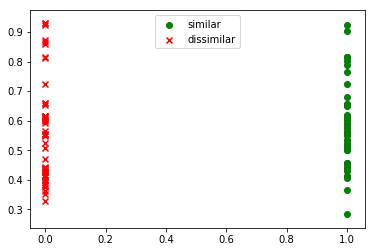

In [240]:
plt.scatter(np.ones(len(similar)), similar, c='g', marker='o', label='similar')
plt.scatter(np.zeros(len(dissimilar)), dissimilar, c='r', marker='x', label='dissimilar')
plt.legend(loc='upper center')

Now that, we have successfully generated our data, we build our siamese network. First, we define the base network which is basically a convolutional network used for feature extraction. We build two convolutional layers with rectified linear unit (ReLU) activations and max pooling followed by flat layer.

In [116]:
def build_base_network(input_shape):
    
    seq = Sequential()
    
    nb_filter = [6, 12]
    kernel_size = 3
    
    
    #convolutional layer 1
    seq.add(Conv2D(nb_filter[0], (kernel_size, kernel_size), input_shape=input_shape, padding='valid'))
    seq.add(Activation('relu'))
    seq.add(MaxPooling2D(pool_size=(2, 2)))  
    seq.add(Dropout(.25))
    
    #convolutional layer 2
    seq.add(Conv2D(nb_filter[1], (kernel_size, kernel_size), padding='valid'))
    seq.add(Activation('relu'))
    seq.add(MaxPooling2D(pool_size=(2, 2))) 
    seq.add(Dropout(.25))

    #flatten 
    seq.add(Flatten())
    seq.add(Dense(128, activation='relu'))
    seq.add(Dropout(0.1))
    seq.add(Dense(50, activation='relu'))
    return seq


Next, we feed the image pair, to the base network, which will return the embeddings that is, feature vectors:

In [117]:
input_dim = x_train.shape[2:]
img_a = Input(shape=input_dim)
img_b = Input(shape=input_dim)

In [118]:
base_network = build_base_network(input_dim)
feat_vecs_a = base_network(img_a)
feat_vecs_b = base_network(img_b)

These feat_vecs_a and feat_vecs_b are the feature vectors of our image pair. Next, we feed this feature vectors to the energy function to compute the distance between them, we use Euclidean distance as our energy function.

In [119]:
def euclidean_distance(vects):
    x, y = vects
    return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

In [120]:
distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([feat_vecs_a, feat_vecs_b])

 Now, we set the epoch length to 13 and we use RMS prop for optimization and define our model.

In [146]:
epochs = 64
rms = RMSprop()

In [147]:
model = Model(inputs=[img_a, img_b], outputs=distance)

Next, we define our loss function as contrastive_loss function and compile the model. 

In [148]:
def contrastive_loss(y_true, y_pred):
    margin = 1
    return K.mean(y_true * K.square(y_pred) + (1 - y_true) * K.square(K.maximum(margin - y_pred, 0)))

def compute_accuracy(predictions, labels):
    return labels[predictions.ravel() < 0.5].mean()

In [149]:
model.compile(loss=contrastive_loss, optimizer=rms)

Now, we generate our data and check our data size. As you can see we have 20,000 data points, out of these 10,000 are genuine pairs and 10,000 are imposite pairs. 

In [150]:
start = 0
step = 100

In [151]:
img_1 = x_train[start:start+step, 0]
img2 = x_train[start:start+step, 1]
similarity = y_train[start:start+step, 0]

In [152]:
model.fit([img_1, img2], similarity, validation_split=.25, batch_size=16, verbose=2, epochs=epochs)

Train on 75 samples, validate on 25 samples
Epoch 1/64
 - 1s - loss: 0.0304 - val_loss: 0.0894
Epoch 2/64
 - 0s - loss: 0.0434 - val_loss: 0.0864
Epoch 3/64
 - 0s - loss: 0.0279 - val_loss: 0.0733
Epoch 4/64
 - 0s - loss: 0.0143 - val_loss: 0.0808
Epoch 5/64
 - 0s - loss: 0.0224 - val_loss: 0.0862
Epoch 6/64
 - 0s - loss: 0.0129 - val_loss: 0.0806
Epoch 7/64
 - 0s - loss: 0.0298 - val_loss: 0.0926
Epoch 8/64
 - 0s - loss: 0.0283 - val_loss: 0.0884
Epoch 9/64
 - 0s - loss: 0.0075 - val_loss: 0.0999
Epoch 10/64
 - 0s - loss: 0.0235 - val_loss: 0.0643
Epoch 11/64
 - 0s - loss: 0.0171 - val_loss: 0.1113
Epoch 12/64
 - 0s - loss: 0.0246 - val_loss: 0.0846
Epoch 13/64
 - 0s - loss: 0.0149 - val_loss: 0.1014
Epoch 14/64
 - 0s - loss: 0.0284 - val_loss: 0.0972
Epoch 15/64
 - 0s - loss: 0.0128 - val_loss: 0.0817
Epoch 16/64
 - 0s - loss: 0.0131 - val_loss: 0.0823
Epoch 17/64
 - 0s - loss: 0.0069 - val_loss: 0.0857
Epoch 18/64
 - 0s - loss: 0.0096 - val_loss: 0.0834
Epoch 19/64
 - 0s - loss: 0.0

Now, we make predictions with test data

In [153]:
pred = model.predict([x_test[:, 0], x_test[:, 1]])
compute_accuracy(pred, y_test)

0.7641968631692807

In [137]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
input_18 (InputLayer)           (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
sequential_8 (Sequential)       (None, 50)           45698       input_17[0][0]                   
                                                                 input_18[0][0]                   
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 1)            0           sequential_8[1][0]         